<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - DeFakeIt : Detecting Deepfake Audio

>Author: Gilbert

---

**Context:**

The rapid advancement of artificial intelligence (AI) technology has revolutionized audio generation, enabling the creation of remarkably realistic synthetic speech. This innovation holds tremendous potential for enhancing accessibility, language translation, and entertainment, benefiting individuals and industries worldwide. However, the same AI capabilities have been exploited for malicious purposes, leading to the proliferation of deepfake audio used in scams, misinformation campaigns, and hate speech. The ease with which AI-generated audio can impersonate individuals and manipulate recordings has raised serious concerns about authenticity and trust in digital communication channels.

This has been a problem in Singapore as well, with recent deepfake video  circulating online impersonating PM Lee voice to promote cryptocurrency investment. [Source : Straits Times Dec 2023](https://www.straitstimes.com/singapore/pm-lee-warns-against-responding-to-deepfake-videos-of-him-promoting-investment-scams)

**Problem Statement:**  

How can we develop a model to effectively detect deepfake audio recordings, distinguishing between genuine human speech and AI generated sound for ensuring audio authenticity and combating the spread of misinformation and fraudulent activities?

**Target Audience:**  

SPF Scam Division

These are the notebooks for this project:  
 1. [`01 Feature Engineering and EDA`](01_feature_engineering_and_EDA.ipynb)
 2. [`02 Baseline Modelling`](02_baseline_modelling.ipynb)
 3. [`03 Hyperparameter Tuning of Baseline Model`](03_hyperparametertuning_traditional_model.ipynb)
 4. [`04 Deep Learning Modelling`](04_deep_learning_modelling.ipynb)

---

 # This Notebook: 03_Deep_Learning_Modelling

 --- 

 This notebook is to go through different approach of creating a prediction model of whether an audio is `fake` or `real` by using deep learning method.

 >*Note: This notebook is run on python 3.10.14 to allow tensorflow version 2.10 model to run on GPU*

 ---

#### **Import Libraries and Dataset**

In [77]:
import pandas as pd 
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D, LSTM, Reshape
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

In [2]:
original = lb.util.find_files('../data/LJSpeech-1.1/wavs')
gen_fb_melgan = lb.util.find_files('../data/generated_audio/ljspeech_full_band_melgan')
gen_hifigan = lb.util.find_files('../data/generated_audio/ljspeech_hifiGAN')
gen_melgan = lb.util.find_files('../data/generated_audio/ljspeech_melgan')
gen_mb_melgan = lb.util.find_files('../data/generated_audio/ljspeech_multi_band_melgan')
gen_p_wavegan = lb.util.find_files('../data/generated_audio/ljspeech_parallel_wavegan')
gen_waveglow = lb.util.find_files('../data/generated_audio/ljspeech_waveglow')

#### **Data Preparation**

---

In order to reduce the processing, we will only take 1/10 of datasets of each categories, while the remaining of the datasets will be used as unseen data.

In [3]:
#create function to filter data
def cut_data(data):
    return data[0:(len(data)//10)]

#create function to convert as Dataframe
def type_label(data,audio_type, label_type):
     df = pd.DataFrame(data, columns = ['audio_file'])
     df['label'] = label_type
     df['audio_type'] = audio_type

     return df

In [4]:
#filter data from each audio categories
train_original = cut_data(original)
train_gen_fb_melgan = cut_data(gen_fb_melgan)
train_gen_hifigan = cut_data(gen_hifigan)
train_gen_melgan = cut_data(gen_melgan)
train_gen_mb_melgan = cut_data(gen_mb_melgan)
train_gen_p_wavegan = cut_data(gen_p_wavegan)
train_gen_waveglow = cut_data(gen_waveglow)


Create DataFrame of Audio Datasets

In [5]:
#create dataframe
train_original_df = type_label(train_original, 'original','real')
train_gen_fb_melgan_df = type_label(train_gen_fb_melgan, 'fb_melgan','fake')
train_gen_hifigan_df = type_label(train_gen_hifigan,'hifigan','fake')
train_gen_melgan_df = type_label(train_gen_melgan, 'melgan','fake')
train_gen_mb_melgan_df = type_label(train_gen_mb_melgan, 'mb_melgan','fake')
train_gen_p_wavegan_df = type_label(train_gen_p_wavegan,'p_wavegan','fake')
train_gen_waveglow_df = type_label(train_gen_waveglow,'waveglow','fake')

In [6]:
#create audio list 
audio_df_list = [train_original_df,
                 train_gen_fb_melgan_df,
                 train_gen_hifigan_df,
                 train_gen_melgan_df,
                 train_gen_mb_melgan_df,
                 train_gen_p_wavegan_df,
                 train_gen_waveglow_df]

#combine all datasets into one 
train_audio_df = pd.DataFrame()
for audio in audio_df_list:
    train_audio_df = pd.concat([train_audio_df,pd.DataFrame(audio)],axis = 0)

#reset the index in the dataframe
train_audio_df = train_audio_df.reset_index(drop=True)

In [7]:
train_audio_df.head()

,audio_file,label,audio_type
0,c:\Users\User\GA\sandbox\capstone_project\data...,real,original
1,c:\Users\User\GA\sandbox\capstone_project\data...,real,original
2,c:\Users\User\GA\sandbox\capstone_project\data...,real,original
3,c:\Users\User\GA\sandbox\capstone_project\data...,real,original
4,c:\Users\User\GA\sandbox\capstone_project\data...,real,original


#### **Feature Extraction**

---

Now that we have our datasets, we will start the feature extraction from the audio file 

We will be using a different approach for the deep learning model. On the previous notebook, for the traditional modelling these are the steps taken:
1. Extract features of audio file(Zero Crossing Rate, MFCCs,Delta MFCCs, Chroma Features, Spectral Centroid), create as csv file
2. Extracted features are used as X variable, to predict Y(real or fake)

For the deep learning approach, instead of extracting these features and convert them into a Dataframe, we will do these steps instead:
1. Transform audio file into image of mel-spectogram in the form of arrays.
2. Use CNN + LSTM to identify the pattern of the mel-spectogram image.
    - CNN is used to identify the pattern of the mel-spectogram.
    - LSTM is used since audio file is a time series.

#### **Convert Mel Spectogram into Arrays**

---

For the deep learning approach, we'll utilize the `Mel spectrogram` image as the input for the neural network architecture. This image is subsequently converted into arrays and resized as necessary to match the neural network's input dimensions. 
Using Mel spectrogram images as input for neural networks enable the utilization of powerful image processing techniques to extract features from audio data, which could facilitate more effective pattern recognition and classification tasks.

The purpose of this code is to convert to Mel-spectogram into arrays. This is done to treat that as an image, which will be input into the Neural Network on the later stage of the notebook. We will be using CNN + LSTM.

In [9]:
# Define fixed shape for spectrograms
desired_number_of_frames = 128
number_of_mel_bins = 128
fixed_shape = (desired_number_of_frames, number_of_mel_bins)

feature_list = []
label_list = []

for index, audio in tqdm(enumerate(train_audio_df['audio_file']), total=len(train_audio_df['audio_file']), desc='Progress Bar'):
    #load audio file
    y, sr = lb.load(audio, sr=44100)
    #extract melspectogram
    mel_spec = lb.feature.melspectrogram(y=y, sr=sr)
    log_mel_spec = lb.power_to_db(mel_spec, ref=np.max)

    # Pad or truncate to ensure fixed shape
    if log_mel_spec.shape[1] < desired_number_of_frames:
        # Pad if the number of frames is less than desired
        pad_width = desired_number_of_frames - log_mel_spec.shape[1]
        padded_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)  # Padding with -80 (for example)
        reshape = padded_spec.reshape(fixed_shape[0], fixed_shape[1], 1)
    elif log_mel_spec.shape[1] > desired_number_of_frames:
        # Truncate if the number of frames is more than desired
        truncate_spec = log_mel_spec[:, :desired_number_of_frames]
        reshape = truncate_spec.reshape(fixed_shape[0], fixed_shape[1], 1)
    else:
        # No need to pad or truncate if the shape matches the desired shape
        reshape = log_mel_spec.reshape(fixed_shape[0], fixed_shape[1], 1)
    
    label = train_audio_df['label'][index]
    feature_list.append(reshape)
    label_list.append(label)

# Convert lists to numpy arrays
feature_array = np.array(feature_list)
label_array = np.array(label_list)


Progress Bar: 100%|██████████| 9170/9170 [04:13<00:00, 36.15it/s]


In [10]:
feature_array.shape

(9170, 128, 128, 1)

#### **Normalize Mel-Spectogram Image Vectors**

---

Now that we have the mel-spectogram vectors, before going into the deep learning, we will normalize them. The purpose of this is to ensure that all pixel values are standardized within the value of 0 and 1. Normalization aids in stabilizing the gradient descent process, promoting more consistent updates across all dimensions of the input data and ultimately improving the model's robustness and generalization capabilities.

In [11]:
#normalize audio vectors 
normalize_list = []
for feature in tqdm(feature_array, desc= 'Progress bar', total = len(feature_array)):
    min_val = np.min(feature)
    max_val = np.max(feature)
    normalized = (feature - min_val) / (max_val - min_val)
    normalize_list.append(normalized)



Progress bar: 100%|██████████| 9170/9170 [00:03<00:00, 2647.21it/s]


### **Neural Network Modelling**

---

We will start to build our deep learning model. We will attempt to use 2 different methods:
1. Binary classification, to classify as `real` and `fake`. The last layer of the neural network uses `sigmoid` activation function as the output is binary
2. Multiclass classification, to classify if the audio falls under `original` category or under one of the 6 `generated` audio categories. The last layer of the neural network uses `softmax` activation function, with 7 classes as possible output

#### **Method 1: Classify Final Output Using Sigmoid**

These are the steps to build the classification neural network architecture:
1. Define input(X) and output(y), prepare train and test data 
2. Create neural network structure

Before building the neural network structure, we will first split our data to train dataset and test dataset. Train dataset are used to train the model, test dataset are used to evaluate how the model perform to predict unseen data

#### **Step 1. Define X and y, Prepare Train and Test Data**

- Input (X) is the arrays converted from mel-spectogram image.
- Output (y) is the label of the audio type which is categorized as:
    1. `real` = 0
    2. `fake` = 1

In [ ]:
#define X and y
X = np.array(normalize_list)

#change y label to binary
label_list_binary = [0 if label == 'real' else 1 for label in label_list]
y = pd.Series(label_list_binary)

In [ ]:
#instantiate train and test split 
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=42, test_size=0.2)

#### **Check Class Proportion**

We will evaluate the proportion of `real` and `fake`

In [ ]:
y.value_counts(normalize=True)

The class distribution is highly imbalanced, with 15% representing 'real' and 85% representing 'fake' Mel spectrogram arrays. While the typical approach to addressing such imbalances involves augmenting the dataset, augmenting the 'real' data may compromise its authenticity in this instance. Consequently, we have opted not to address the class imbalance and will proceed with modeling and evaluating performance accordingly.

#### **Check the X and y shape**

To ensure that X and y variable have the same shape. This is critical to avoid errors during modelling.

In [ ]:
X_train.shape

(7336, 128, 128, 1)

In [ ]:
y_train.shape

(7336,)

#### **Step 2: Create Neural Network Structure**

On this step, we will create the neural network structure. It will be the combination of CNN and LSTM. The output (last layer) of the neural network will be a binary classification, using `sigmoid` as its activation function.

In [35]:
#define input shape
input_shape = (128,128,1)

#instantiate empty model of Sequential
nn_model = Sequential()

#add Convolutional Layer
nn_model.add(Conv2D(filters = 32,
                    kernel_size = (3,3), 
                    padding = 'same',
                    activation = 'relu',
                    input_shape = input_shape))
nn_model.add(MaxPooling2D(pool_size=(2,2)))
nn_model.add(Dropout(0.5))
nn_model.add(Conv2D(filters = 64,
                    kernel_size = (3,3), 
                    padding = 'same',
                    activation = 'relu',
                    input_shape = input_shape))
nn_model.add(MaxPooling2D(pool_size=(2,2)))
nn_model.add(Dropout(0.5))
nn_model.add(Conv2D(filters = 64,
                    kernel_size = (3,3), 
                    padding = 'same',
                    activation = 'relu',
                    input_shape = input_shape))
nn_model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten to 1D array
nn_model.add(Flatten())

#reshape model before LSTM
nn_model.add(Reshape((16,1024))) 

#add LSTM layer
nn_model.add(LSTM(32,activation='tanh'))
nn_model.add(Dense(32,activation='relu'))

#final layer is for binary output
nn_model.add(Dense(1, activation='sigmoid'))



Summary of the neural network

In [36]:
#overview of the model summary
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 64)       

In [12]:
#create recall function
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [23]:
#compile model
opt = Adam(learning_rate=0.00001)
nn_model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy',recall])

In [39]:

#fit the neural network model
hist = nn_model.fit(X_train,
                    y_train,
                    batch_size = 32,
                    validation_data = (X_test,y_test),
                    epochs = 100)

Epoch 1/100
230/230 [==============================] - 7s 24ms/step - loss: 0.6274 - accuracy: 0.7959 - recall: 0.9170 - val_loss: 0.6133 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 2/100
230/230 [==============================] - 5s 21ms/step - loss: 0.4723 - accuracy: 0.8571 - recall: 1.0000 - val_loss: 0.4985 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 3/100
230/230 [==============================] - 5s 21ms/step - loss: 0.4276 - accuracy: 0.8571 - recall: 1.0000 - val_loss: 0.4492 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 4/100
230/230 [==============================] - 5s 21ms/step - loss: 0.4137 - accuracy: 0.8571 - recall: 1.0000 - val_loss: 0.4286 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 5/100
230/230 [==============================] - 5s 21ms/step - loss: 0.4108 - accuracy: 0.8571 - recall: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 6/100
230/230 [==============================] - 5s 21ms/step - loss: 0.4103 - accur

#### **Evaluate loss, accuracy and recall score**

In [13]:
#create function to plot loss function, accuracy and recall plot

def nn_plot(history):
    sns.set_style('whitegrid')
    #create subplots 
    fig, ax = plt.subplots(3,1, figsize = (8,20))
    
    #define loss function variable
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    #define accuracy variable
    train_accuracy = history.history['accuracy']
    test_accuracy = history.history['val_accuracy']

    #define recall variable
    train_recall = history.history['recall']
    test_recall = history.history['val_recall']

    #Generate loss function plot 
    ax[0].plot(train_loss, label='Training Loss')
    ax[0].plot(test_loss, label='Testing Loss')
    ax[0].set_title("Loss Score Over Epoch", weight = 'bold', fontsize = 15)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    #Generate accuracy plot 
    ax[1].plot(train_accuracy, label='Training Accuracy')
    ax[1].plot(test_accuracy, label='Testing Accuracy')
    ax[1].set_title("Accuracy Score Over Epoch", weight = 'bold', fontsize = 15)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    #Generate recall plot
    ax[2].plot(train_recall, label='Training Recall')
    ax[2].plot(test_recall, label='Testing Recall')
    ax[2].set_title("Recall Score Over Epoch", weight = 'bold', fontsize = 15)
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Recall')
    ax[2].legend()


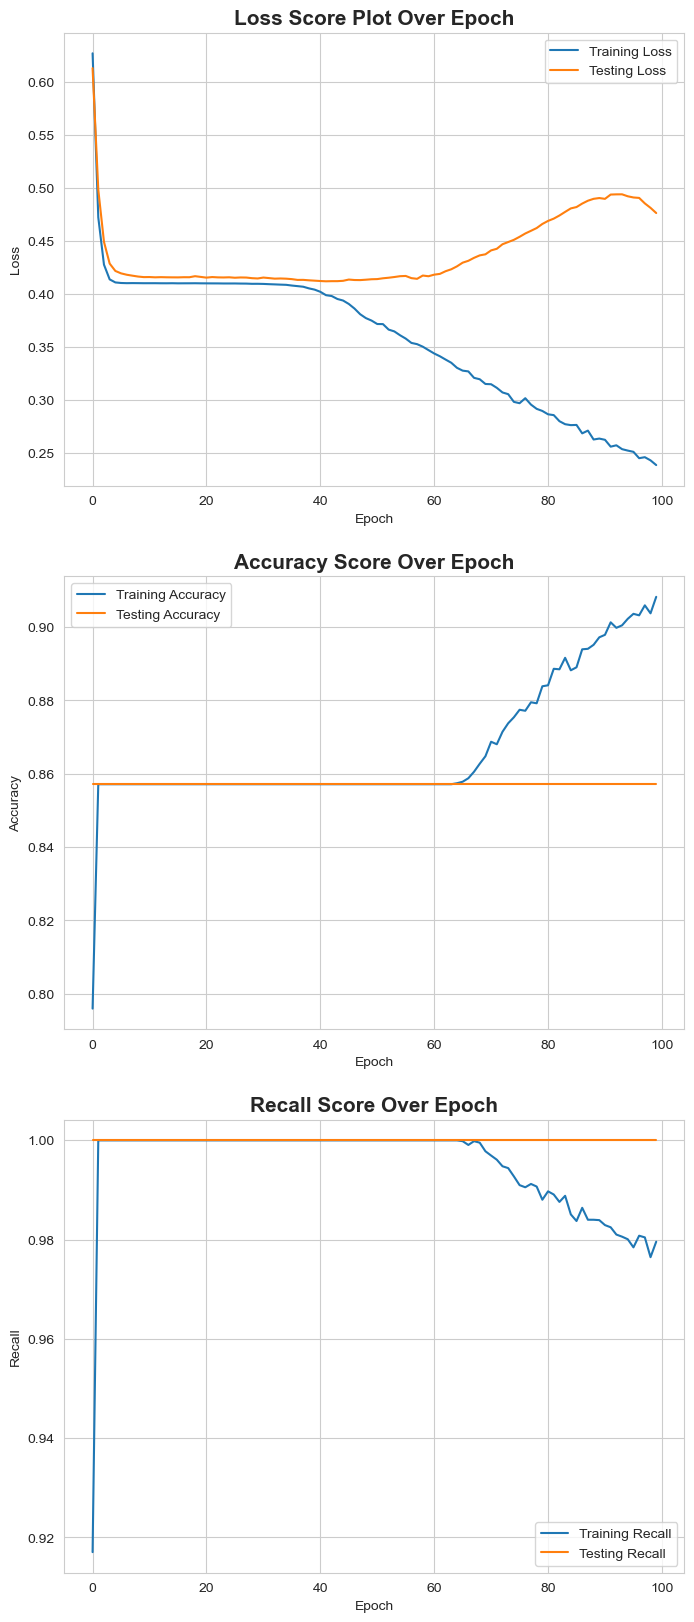

In [130]:
nn_plot(hist)

Observing the plot, it's evident that the loss function scores is typically constant from epoch 5 to 40 for both training and test sets. Subsequently, the test loss score escalates while the train loss declines, suggesting potential overfitting of the model beyond epoch 40. Regarding the accuracy and recall plots, the scores remain consistent across all epochs, possibly influenced by the imbalanced distribution between `real` and `fake` classes, leading to a bias in the model's predictions towards the majority class (`fake`).

We will proceed to `method 2` with different approach to evaluate how the model perform

#### **Method 2: Classify Final Output Using Softmax (Multi-class Classification)**

On the second approach, the neural network final output is a multi-class classification of 7 classes. The classes are identified and labelled as the following:

|Audio Class|Class Label|
|---|---|
|Original|0|
|Full Band Mel GAN|1|
|HiFi GAN|2|
|Multi Band GAN|3|
|Mel GAN|4|
|Parallel WaveGAN|5|
|WaveGlow|6|

The steps taken to create the neural network architecture is similar to method 1. These are the steps:
1. Define input(X) and output(y), prepare train and test data 
2. Create neural network structure

In [14]:
#overview of data 
train_audio_df.head()

,audio_file,label,audio_type
0,c:\Users\User\GA\sandbox\capstone_project\data...,real,original
1,c:\Users\User\GA\sandbox\capstone_project\data...,real,original
2,c:\Users\User\GA\sandbox\capstone_project\data...,real,original
3,c:\Users\User\GA\sandbox\capstone_project\data...,real,original
4,c:\Users\User\GA\sandbox\capstone_project\data...,real,original


In [15]:
#list all type of audio type 
np.unique(train_audio_df['audio_type'])

array(['fb_melgan', 'hifigan', 'mb_melgan', 'melgan', 'original',
       'p_wavegan', 'waveglow'], dtype=object)

In [16]:
#function to label audio type 
def audio_type_class(audio_type):
    if audio_type == 'original':
        return 0
    elif audio_type == 'fb_melgan':
        return 1
    elif audio_type == 'hifigan':
        return 2
    elif audio_type == 'mb_melgan':
        return 3
    elif audio_type == 'melgan':
        return 4
    elif audio_type == 'p_wavegan':
        return 5
    elif audio_type == 'waveglow':
        return 6
#convert audio type to class of int 
train_audio_df['class'] = train_audio_df['audio_type'].apply(audio_type_class)

#### **Step 1: Define X and y, Prepare Train and Test Data**

- Input (X) is the arrays converted from mel-spectogram image.
- Output (y) is the classes of each audio type stated at the starting of `Method 2`.

In [17]:
#X will be the same as method 1
X = np.array(normalize_list)

#convert y into categorical variables
y = to_categorical(train_audio_df['class'])

#### **Check Class Proportion**

In [18]:
train_audio_df['class'].value_counts(normalize=True)

class
0    0.142857
1    0.142857
2    0.142857
4    0.142857
3    0.142857
5    0.142857
6    0.142857
Name: proportion, dtype: float64

All of the classes are proportionally balanced.

#### **Split Train and Test Data**

In [19]:
#instantiate train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42, test_size=0.2)

#### **Create Neural Network Structure**

The neural network is using similar architecture as `method 1`. The only difference is on the last layer, which is now multiclass output with 7 class, using activation function `softmax`. `softmax` is suitable activation function for multiclass output.

In [20]:
#create neural network
tf.random.set_seed(42)

#define input shape
input_shape = (128,128,1)

#instantiate empty Sequential model
nn_model2 = Sequential()

#add Convolutional 2D Layer
nn_model2.add(Conv2D(filters = 64,
                    kernel_size = (3,3), 
                    padding = 'same',
                    activation = 'relu',
                    input_shape = input_shape))

nn_model2.add(MaxPooling2D(pool_size=(2,2)))
nn_model2.add(Dropout(0.5))
nn_model2.add(Conv2D(filters = 64,
                    kernel_size = (3,3), 
                    padding = 'same',
                    activation = 'relu',
                    input_shape = input_shape))

nn_model2.add(MaxPooling2D(pool_size=(2,2)))
nn_model2.add(Dropout(0.5))
nn_model2.add(Conv2D(filters = 64,
                    kernel_size = (3,3), 
                    padding = 'same',
                    activation = 'relu',
                    input_shape = input_shape))

nn_model2.add(MaxPooling2D(pool_size=(2,2)))

#Flatten 1D array
nn_model2.add(Flatten())
nn_model2.add(Reshape((16,1024))) 

#add LSTM layer
nn_model2.add(LSTM(32,activation='tanh'))
nn_model2.add(Dense(32,activation='relu'))
#last layer to classify into one of the 7 classes
nn_model2.add(Dense(7, activation='softmax'))


In [21]:
nn_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

In [22]:
#compile model
opt = Adam(learning_rate=0.0001)
nn_model2.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy',recall])

In [23]:
#fit model
hist2 = nn_model2.fit(X_train,
                    y_train,
                    batch_size = 32,
                    validation_data = (X_test,y_test),
                    epochs = 120)


Epoch 1/120
230/230 [==============================] - 21s 35ms/step - loss: 1.9470 - accuracy: 0.1431 - recall: 0.0000e+00 - val_loss: 1.9459 - val_accuracy: 0.1494 - val_recall: 0.0000e+00
Epoch 2/120
230/230 [==============================] - 7s 31ms/step - loss: 1.9463 - accuracy: 0.1401 - recall: 0.0000e+00 - val_loss: 1.9459 - val_accuracy: 0.1423 - val_recall: 0.0000e+00
Epoch 3/120
230/230 [==============================] - 7s 31ms/step - loss: 1.9462 - accuracy: 0.1385 - recall: 0.0000e+00 - val_loss: 1.9458 - val_accuracy: 0.1330 - val_recall: 0.0000e+00
Epoch 4/120
230/230 [==============================] - 7s 31ms/step - loss: 1.9460 - accuracy: 0.1373 - recall: 0.0000e+00 - val_loss: 1.9458 - val_accuracy: 0.1772 - val_recall: 0.0000e+00
Epoch 5/120
230/230 [==============================] - 7s 31ms/step - loss: 1.9457 - accuracy: 0.1529 - recall: 0.0000e+00 - val_loss: 1.9455 - val_accuracy: 0.1903 - val_recall: 0.0000e+00
Epoch 6/120
230/230 [============================

#### **Evaluate loss, accuracy and recall**

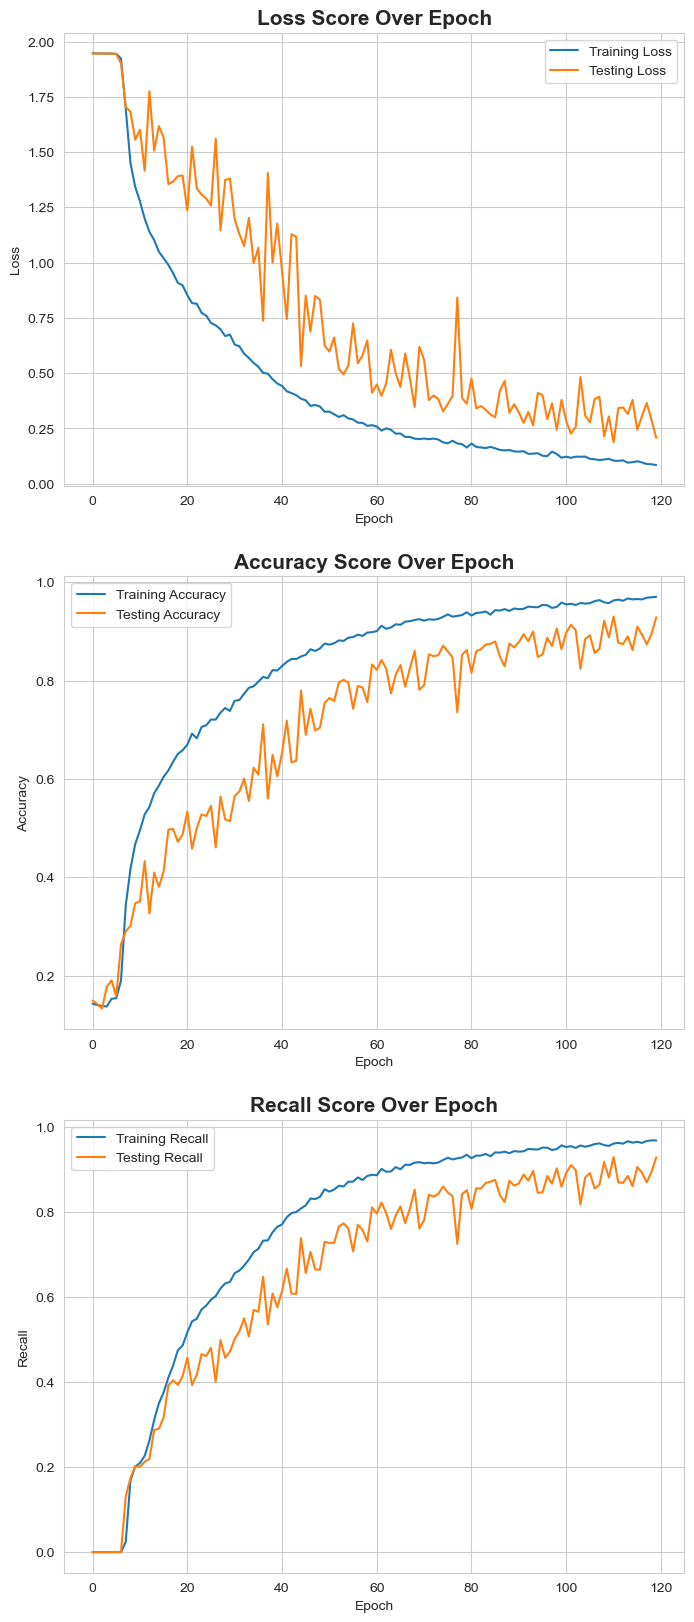

In [26]:
nn_plot(hist2)

In [27]:
#final recall and accuracy score
train_recall_score = hist2.history['recall'][-1]
test_recall_score = hist2.history['val_recall'][-1]

train_accuracy_score = hist2.history['accuracy'][-1]
test_accuracy_score = hist2.history['val_accuracy'][-1]

print(f"Train accuracy score : {train_accuracy_score} ")
print(f"Test accuracy score : {test_accuracy_score} ")
print(f"Train recall score : {train_recall_score} ")
print(f"Test recall score : {test_recall_score} ")



Train accuracy score : 0.9701471924781799 
Test accuracy score : 0.9285714030265808 
Train recall score : 0.967391312122345 
Test recall score : 0.9278017282485962 


Based on the plot above, we can see the following:7
1. The validation loss score of the test data has a decreasing trend.
2. The accuracy and recall score of the test data has a increasing trend.

Overall, these trends suggest progressive enhancement in model performance across epochs.

Comparing `method 1` and `method 2`, the method 2 will be selected as the final model. The reason of selection is `method 2` shows better performance over `method 1`. `Method 2` are trained with balanced class which enables it to generally predict better than `method 1`

Summary of final score from the last epoch:

|Deep Learning Model|Accuracy|Recall|
|---|---|---|
|CNN + LSTM|Train score = 0.970 <br> Test score = 0.928|Train score = 0.967 <br> Test Score = 0.927| 

#### **Evalute Confusion Matrix and ROC**

For evaluation, we will utilize the following tools:

1. Confusion Matrix 

A table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It can help to calculate required metrics such as accuracy, precision, recall, specificity, and F1 Score.

2. ROC Curve

A graphical representation of a binary classification model's performance across different threshold values. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds. The curve provides insights into the trade-offs between sensitivity and specificity, with a higher area under the curve (AUC) indicating better model performance.

#### 1. Confusion Matrix

58/58 [==============================] - 1s 10ms/step


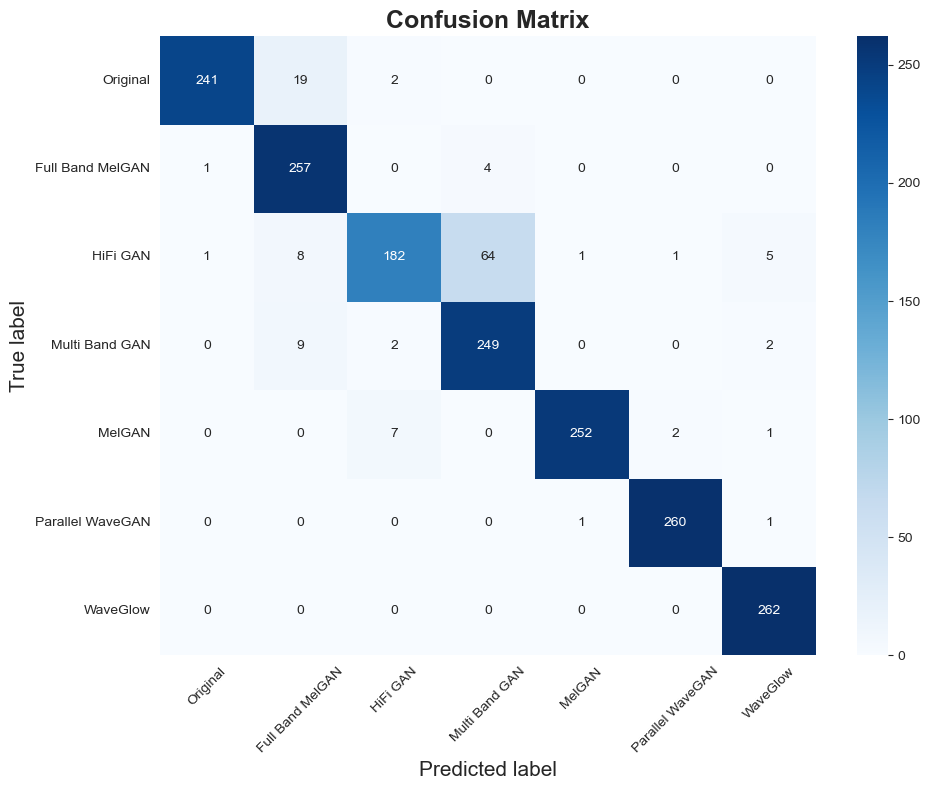

In [74]:
#confusion matrix
pred = nn_model2.predict(X_test)
y_pred = np.argmax(pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)
class_name = ['Original', 'Full Band MelGAN', 'HiFi GAN','Multi Band GAN', 'MelGAN','Parallel WaveGAN', 'WaveGlow']
# Calculate the confusion matrix using the explicitly referenced function
conf_matrix = cm(y_true, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted label', fontsize = 15)
plt.ylabel('True label', fontsize = 15)
plt.title('Confusion Matrix', fontsize = 18, weight = 'bold')

plt.xticks(ticks=np.arange(len(class_name)) + 0.5, labels = class_name, rotation = 45);
plt.yticks(ticks=np.arange(len(class_name)) + 0.5, labels = class_name, rotation = 0);
plt.tight_layout()  
plt.show();



Based on the confusion matrix, when examining the diagonal elements representing `true` scores, we observe consistently high values. This suggests that the model effectively discerns the classes, facilitating accurate classification of unseen data.

Upon examination of the `original` column in the confusion matrix, it's evident that the model consistently correctly predicts audio labeled as `original`. Notably, there are minimal instances of `original` data classified into any of the 'generated' audio classes. This underscores the model's ability to effectively distinguish whether an audio sample is `original` or not, which is crucial for our application. Misclassifying `generated` audio as `original` could potentially mislead users, as they might perceive the audio as `real` when it is actually `fake`.

#### 2. ROC Curve  

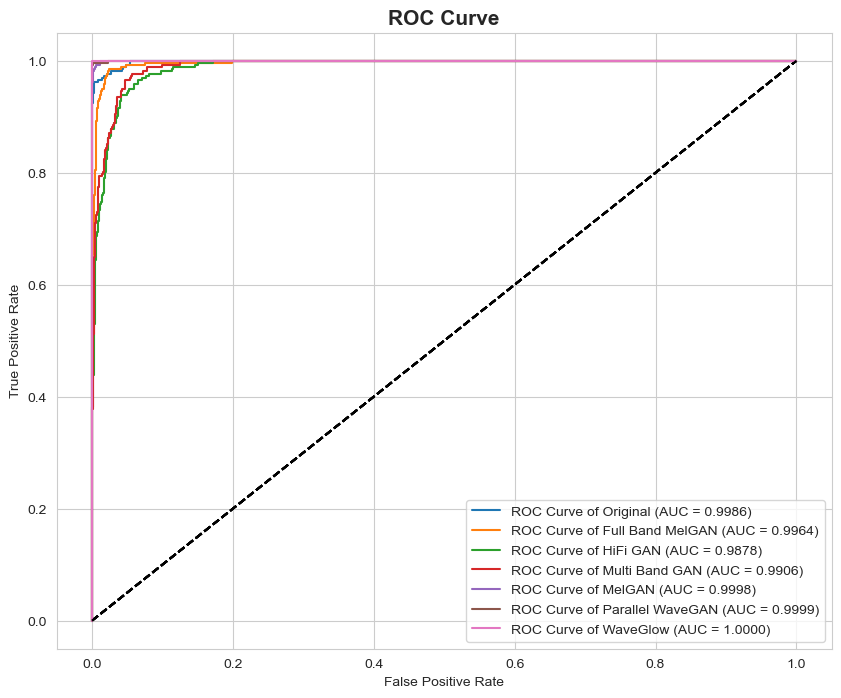

In [29]:
#plot ROC curve 
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label = f"ROC Curve of {class_name[i]} (AUC = {roc_auc[i]:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')

plt.legend()
plt.title("ROC Curve", fontsize = 15, weight = 'bold');
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate");

Looking at the AUC (Area Under Curve) score for each class, which generally exceeds 0.98, indicates strong performance in distinguishing between classes. This suggests that each class can effectively differentiate unseen data, aiding accurate classification.

#### **Save model and export**

This is done to export the model weights. It will be used for streamlit app to predict the audio file that is uploaded

In [109]:
nn_model2.save_weights("streamlit/model_weights.h5")

### **Model Prediction**

In this part of the notebook, we will attempt to see how the model perform to predict an unseen data

First we will create a function to process an audio to vectors

In [30]:
# Define fixed shape for spectrograms
desired_number_of_frames = 128
number_of_mel_bins = 128
fixed_shape = (desired_number_of_frames, number_of_mel_bins)

#create function to process load and process audio file 
def audio_process(audio):
    y, sr = lb.load(audio, sr=44100)
    mel_spec = lb.feature.melspectrogram(y=y, sr=sr)
    log_mel_spec = lb.power_to_db(mel_spec, ref=np.max)

    # Pad or truncate to ensure fixed shape
    if log_mel_spec.shape[1] < desired_number_of_frames:
        # Pad if the number of frames is less than desired
        pad_width = desired_number_of_frames - log_mel_spec.shape[1]
        padded_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)  # Padding with -80 (for example)
        reshape = padded_spec.reshape(fixed_shape[0], fixed_shape[1], 1)
    elif log_mel_spec.shape[1] > desired_number_of_frames:
        # Truncate if the number of frames is more than desired
        truncate_spec = log_mel_spec[:, :desired_number_of_frames]
        reshape = truncate_spec.reshape(fixed_shape[0], fixed_shape[1], 1)
    else:
        # No need to pad or truncate if the shape matches the desired shape
        reshape = log_mel_spec.reshape(fixed_shape[0], fixed_shape[1], 1)

    # Convert lists to numpy arrays
    feature_array = reshape.reshape(1,128,128,1)
    
    #normalize the arrays
    min_val = np.min(feature_array)
    max_val = np.max(feature_array)
    normalized = (feature_array - min_val) / (max_val - min_val)
    
    

    return np.array(normalized)

1. Test with unseen data from dataset

For the train dataset, we are only using 1310 audio files from original , and each different types of GANs model. We will test by using the audio files that are not part of the train data. Train datasets are using files from the range of 0 to 1309. We will select the files outside of this range as our testing data to evaluate how the model perform on unseen data

In [78]:
random_number = np.random.choice(range(1310,13100),1)
#select unseen original audio 
test_audio_1 = audio_process(original[int(random_number)])
result1 = nn_model2.predict(test_audio_1)
print(result1)

if np.argmax(result1) == 0:
    print("Real")
else:
    print("Fake")


1/1 [==============================] - 0s 41ms/step
[[9.9889696e-01 1.0999913e-03 2.5678576e-06 8.0672059e-08 2.0110578e-07
  1.8933038e-08 1.5121266e-07]]
Real


The model detects that the original audio is real.

In [79]:
random_number = np.random.choice(range(1310,13100),1)
test_audio_2 = audio_process(gen_fb_melgan[int(random_number)])
result2 = nn_model2.predict(test_audio_2)
print(result2)

if np.argmax(result2) == 0:
    print("Real")
else:
    print("Fake")

1/1 [==============================] - 0s 33ms/step
[[1.5838817e-04 9.9862552e-01 4.1849104e-05 1.0847774e-03 1.9168493e-10
  7.0516073e-09 8.9486581e-05]]
Fake


The model detects that the generated audio is fake.

2. Test with sample generated from [Eleven Labs](https://elevenlabs.io/) Female Voice

Eleven labs is a platform which can generate an audio with their AI voice generator. We will download a sample from there and test how our model detect the audio file. The first test case will be a female generated voice.

In [33]:
#test sample from elevenlabs
elevenlabs_loc = '../data/elevenlabs/elevenlabs_sample.mp3'

In [34]:
elevenlabs_test = audio_process(elevenlabs_loc)

In [35]:
result2 = nn_model2.predict(elevenlabs_test)
print(result2)

if np.argmax(result2) == 0:
    print("Real")
else:
    print("Fake")

1/1 [==============================] - 0s 20ms/step
[[1.46752940e-02 8.96755993e-01 8.53235275e-03 5.65289743e-02
  1.05807395e-07 5.03133808e-04 2.30041910e-02]]
Fake


The model detects that it is fake.

3. Test with sample generated from [Eleven Labs](https://elevenlabs.io/) Male Voice

Second test from Eleven Labs is by testing how the model perform when detecting an audio file generated with male voice

In [68]:
#test sample from elevenlabs
elevenlabs_loc_2 = '../data/elevenlabs/elevenlabs_daniel.mp3'
elevenlabs_test_2 = audio_process(elevenlabs_loc)

In [69]:
result3 = nn_model2.predict(elevenlabs_test_2)
print(result3)

if np.argmax(result3) == 0:
    print("Real")
else:
    print("Fake")

1/1 [==============================] - 0s 382ms/step
[[1.46752940e-02 8.96755993e-01 8.53235275e-03 5.65289743e-02
  1.05807395e-07 5.03133808e-04 2.30041910e-02]]
Fake


The model detects that it is fake.

---

### **Conclusion**

A classification model built with combination of `Convolutional Neural Network(CNN) + Long Short Term Memory` has been created, which could distinguish if the audio is `real` or `fake`. A proof of concept created can give a prediction of the audio file that is uploaded into it. Having this model could alert the community if the audio that they received is `real` or `fake`.

### **Limitation** 

These are the limitations that are identified from the model:
1. The model's performance could be impacted when applied to audio generated by a new AI system with substantial differences from those encountered during its training.
2. The model's effectiveness may be diminished when detecting audio in environments with significant background noise.

### **Future Work and Recommendation**

The next step is to work with SPF Scam Division web developer team to implement this chatbot to their webpage. The purpose is so that user can use that platform to upload the audio files that they wish to check if it is `real` or `fake`. 

To address the limitation and improve the model robustness, the following steps will be taken:
1. Collecting data from potentially new types of deepfake audio generator models and incorporating them into the training data.
2. Augment the dataset by introducing various types and levels of background noise to simulate real-world environments. 